In [22]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pyfits
from collections import OrderedDict
from astropy.coordinates import SkyCoord
import healpy as hp
from astropy import units as u

In [14]:

#Find this file at : https://github.com/dscolnic/Pantheon/blob/master/lcparam_full_long_zhel.txt
panarr = np.genfromtxt('Pantheon/lcparam_full_long_zhel.txt', skip_header=1)
pannames = np.asarray([k.split()[0] for k in open('Pantheon/lcparam_full_long_zhel.txt').readlines()[1:]])

#And this one at https://github.com/cmbant/CosmoMC/blob/master/data/jla_lcparams.txt
#Or download from http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html
jlarr = np.genfromtxt('jla_likelihood_v6/data/jla_lcparams.txt', skip_header=1)
jlnames = np.asarray([k.split()[0] for k in open('jla_likelihood_v6/data/jla_lcparams.txt').readlines()[1:]])
plines = open('Pantheon/lcparam_full_long_zhel.txt').readlines()[1:]

In [15]:
jlnamesn = np.asarray([k.replace('sn', '').replace('SDSS','') for k in jlnames])#Because pantheon names dont seem to have these prefixes. You can verify they're still the same SN, by comparing the directions

In [16]:
zhdiffs=OrderedDict()
panzs = OrderedDict()
jlzs = OrderedDict()
jlras = OrderedDict()
jldecs = OrderedDict()
for i in range(len(jlnamesn)):
    #print jlnamesn[i], pannames[pannames==jlnamesn[i]]
    if jlnamesn[i] in pannames:
        #print jlarr.transpose()[2][i], panarr.transpose()[2][pannames==jlnamesn[i]]
        zhdiffs[jlnamesn[i]] = np.absolute(jlarr.transpose()[2][i] - panarr.transpose()[2][pannames==jlnamesn[i]][0])#the difference between pantheon and jla redshifts (zhel)
        panzs[jlnamesn[i]] = panarr.transpose()[2][pannames==jlnamesn[i]][0]#pantheon zhel
        jlras[jlnamesn[i]] = jlarr.transpose()[18][i]
        jldecs[jlnamesn[i]] = jlarr.transpose()[19][i]
        jlzs[jlnamesn[i]] = jlarr.transpose()[2][i]#jla redshifts
        

In [18]:
#make everything into numpy arrays
jnn = np.asarray(zhdiffs.keys())
jnzd = np.asarray(zhdiffs.values())
jlzarr = np.asarray(jlzs.values())
panzarr = np.asarray(panzs.values())
jlraarr = np.asarray(jlras.values())
jldecarr = np.asarray(jldecs.values())

In [8]:
#print jnn[jnzd>0.0025]
#print len(jnn[jnzd>0.0025])
#Generate the rows of tables 1 and 2 in the arxiv note. Note that the last 2 rows have to be treated differently (prefix sn instead of SDSS)
for snn, zd, jlz, panz in zip(jnn[jnzd>0.0025], jnzd[jnzd>0.0025], jlzarr[jnzd>0.0025], panzarr[jnzd>0.0025]):
    #print snn, zd, jlz, panz
    print 'SDSS'+snn + ' & ', str(jlz),' & ', snn + ' & ', str(panz), ' & ', str(zd), ' & ', str(zd/0.0005) + ' $\sigma$ \\\\' 

SDSS12881 &  0.233  &  12881 &  0.237838  &  0.004838  &  9.676 $\sigma$ \\
SDSS12927 &  0.175  &  12927 &  0.189638  &  0.014638  &  29.276 $\sigma$ \\
SDSS13044 &  0.121  &  13044 &  0.125735  &  0.004735  &  9.47 $\sigma$ \\
SDSS13136 &  0.366  &  13136 &  0.371627  &  0.005627  &  11.254 $\sigma$ \\
SDSS13152 &  0.207  &  13152 &  0.203311  &  0.003689  &  7.378 $\sigma$ \\
SDSS13305 &  0.201  &  13305 &  0.214557  &  0.013557  &  27.114 $\sigma$ \\
SDSS13727 &  0.221  &  13727 &  0.226402  &  0.005402  &  10.804 $\sigma$ \\
SDSS13796 &  0.145  &  13796 &  0.148518  &  0.003518  &  7.036 $\sigma$ \\
SDSS14261 &  0.281  &  14261 &  0.285517  &  0.004517  &  9.034 $\sigma$ \\
SDSS14331 &  0.214  &  14331 &  0.220905  &  0.006905  &  13.81 $\sigma$ \\
SDSS14397 &  0.371  &  14397 &  0.386084  &  0.015084  &  30.168 $\sigma$ \\
SDSS14437 &  0.144  &  14437 &  0.149098  &  0.005098  &  10.196 $\sigma$ \\
SDSS14481 &  0.255  &  14481 &  0.243249  &  0.011751  &  23.502 $\sigma$ \\
SDSS15

In [23]:
#Now let's see where in the sky these sources are

def plot_oneset(ax, RA,Dec,org=0,title='Mollweide projection', projection='mollweide', color='red', size=2.0, marker='o', fillstyle='full', line=False, alpha=0.8):
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    if not line:
        ax.scatter(np.radians(x),np.radians(Dec), alpha=alpha, s=size, color=color, marker=marker)
    else:
        ax.plot(np.radians(x),np.radians(Dec), alpha=0.8, color=color, lw=2, ls='--')

def EquatorialtoGalactic(ra, dec):
    skc = SkyCoord(ra = ra*u.degree, dec =dec*u.degree)
    return skc.galactic.l.value, skc.galactic.b.value

ls, bs = EquatorialtoGalactic(jlraarr, jldecarr)

CMBdipra = 168.0
CMBdipdec = -7.0
SMAC2ra = 147.3 # 200h^-1 bulk flow, 372+/-127
SMAC2dec = -46.0
TwoMppra = 194.802
TwoMppdec = -56.855

CMBdipl, CMBdipb = EquatorialtoGalactic(CMBdipra, CMBdipdec)
SMAC2l, SMAC2b = EquatorialtoGalactic(SMAC2ra, SMAC2dec)
TwoMppl, TwoMppb = EquatorialtoGalactic(TwoMppra, TwoMppdec)


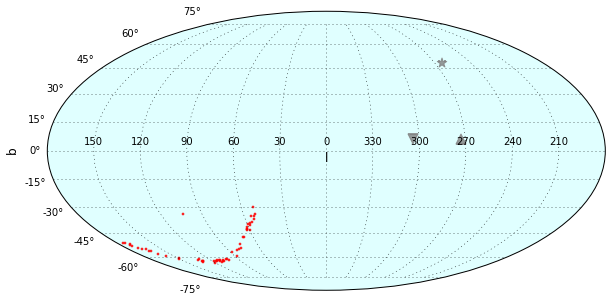

In [30]:
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
org = 0
tick_labels = np.remainder(tick_labels+360+org,360)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide', axisbg ='LightCyan')

plot_oneset(ax, ls[jnzd>0.0025], bs[jnzd>0.0025], color='red', size=3.0)
plot_oneset(ax, np.asarray([CMBdipl]), np.asarray([CMBdipb]), color='gray', marker='*', size=100, fillstyle='none')
plot_oneset(ax, np.asarray([SMAC2l]), np.asarray([SMAC2b]), color='gray', marker='^', size=100, fillstyle='none')
plot_oneset(ax, np.asarray([TwoMppl]), np.asarray([TwoMppb]), color='gray', marker='v', size=100, fillstyle='none')
ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
#ax.set_title(title)
#ax.title.set_fontsize(15)
ax.set_xlabel("l")
ax.xaxis.label.set_fontsize(12)
ax.set_ylabel("b")
ax.yaxis.label.set_fontsize(12)
ax.grid(True, which='both')

In [ ]:
plt.hist(np.log10(zhdiffs.values()), bins=np.linspace(-6, +6, 20))
plt.show()

In [ ]:
for jn in jlnamesn:
    print jn
    if jn in pannames:
        print 'in Pantheon'
        